The results of injection recovery on ~300 experiments (6 per star, so on 50 randomly selected contact EBs of the ~1000 that I have) are given in `cbp/results/injrecovresult/plots`. Notably, looking at `completeness_top1_Rp_vs_periodcbp.pdf`, it's clear that assuming $R_\star = 1.5R_\odot$ for all of the injected planets only gives us reasonable sensitivity down to $\sim 8 R_\oplus$. We want to be sensitive down to like 2x smaller planets. Which means a factor of 4x increase in sensitivity (i.e. a factor of 4 improvement in RMS required of standard eclipsing binary subtraction).

So, why are we not detecting the smaller injected things? More pointedly -- why is our subtraction giving us residuals that are too big to find them?

Look at the fluxes vs time to see if there's time-variability left-over (there should be for many).

In [1]:
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt

The import Q is: do the residuals still have periodic variability? (& is it making it harder for us to find dips?)

In [2]:
np.random.seed(42)

In [3]:
run ../src/inj_recov.py

In [4]:
def plot_random_quarter():
    '''
    Flux vs time for a random quarter of data.
    '''

    origstage = 'dipsearch_inj'
    δ = 1/16./100. # try to ignore injection
    stage = origstage + '_' + str(δ)

    df = pd.read_csv('../results/injrecovresult/irresult_sap_top1.csv')
    kicids = np.unique(df['kicid'])
    kicid_ind = np.random.randint(low=0, high=len(kicids))
    
    lcd = load_lightcurve_data(kicids[kicid_ind], stage=stage)
    allq = load_allq_data(kicids[kicid_ind], stage=stage)
    
    qnums = list(lcd.keys())
    qnum = np.random.randint(low=min(qnums), high=max(qnums))
    while qnum not in qnums:
        qnum = np.random.randint(low=min(qnums), high=max(qnums))

    lc = lcd[qnum]['redtr']['sap']
    fluxs = lc['fluxs'] - lc['fitfluxs_legendre']
    times = lc['times']
    
    #phase dispersion minimization, what do we see?
    #nb: one logic for this could be: if RMS is too big to reasonably
    #find an Rp=4Rearth (6,8,10 whatever) planet, then try to continue
    #whitening.
    
    #OR, frankly, implementing the GP regression here would be cool too.
    #b/c the timescale is now all unknown and stuff too
    
    plt.close('all')
    f, axs = plt.subplots(figsize=(16,10), nrows=3, ncols=1)
    axs[0].plot(times, fluxs, color='black', linestyle='-', marker='o', markersize=0.1, lw=0.5)
    axs[1].plot(times, fluxs, color='black', linestyle='-', marker='o', markersize=1, lw=0.5)
    axs[2].plot(times, fluxs, color='black', linestyle='-', marker='o', markersize=1, lw=0.5)
    
    a1_xlim = axs[1].get_xlim()
    a1_xstart = np.random.uniform(low=min(a1_xlim), high=max(a1_xlim)-10)
    axs[1].set_xlim([a1_xstart, a1_xstart+10.])
    
    a0_xlim = axs[0].get_xlim()
    a2_xstart = np.random.uniform(low=min(a0_xlim), high=max(a0_xlim)-10)
    while abs(a2_xstart - a1_xstart)<10. :
        a2_xstart = np.random.uniform(low=min(a0_xlim), high=max(a0_xlim)-10)
    axs[2].set_xlim([a2_xstart, a2_xstart+10.])
    
    a0ylim = axs[0].get_ylim()
    axs[0].vlines([a1_xstart, a1_xstart+10.], min(a0ylim), max(a0ylim), linestyle='--')
    axs[0].vlines([a2_xstart, a2_xstart+10.], min(a0ylim), max(a0ylim), linestyle='--')
    axs[0].set_ylim(a0ylim)
    axs[0].set(ylabel='redetr flux')

    f.tight_layout()
    fname = str(kicids[kicid_ind])+'_'+stage+'.png'
    f.savefig('../results/eb_subtraction_diagnostics/'+fname, dpi=300)
    
def plot_many_quarters():
    for _ in range(100):
        plot_random_quarter()

I reimplemented this in `src/do_dtr_residuals_have_periodic_variability.py`. The answer is yeah, dude.

What if we could use signal processing methods to do something about this?

Demoing butterworth

In [5]:
#from http://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
%matplotlib inline

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='lowpass')
    return b, a

def butter_bandpass_filter(data, lowcut, fs, order=5):
    b, a = butter_bandpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def run_nice_sampling():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 400.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 2415 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, fs, order=9)
    plt.plot(t, y-0.1, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='best', fontsize='x-small')

    plt.show()

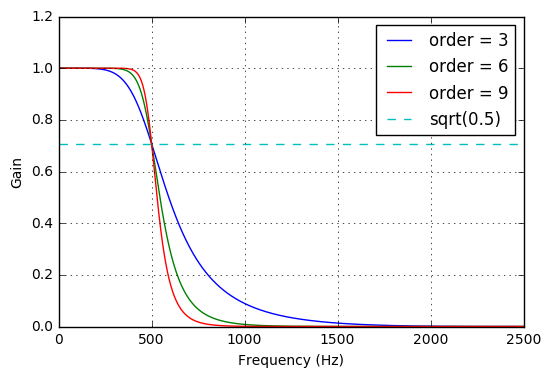

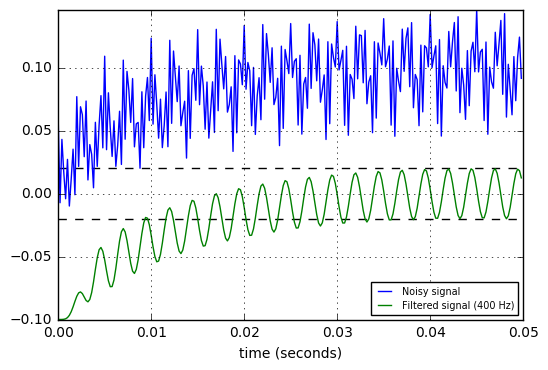

In [6]:
run_nice_sampling()

In [7]:
def run_worse_sampling():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    # drop 20% of data points (e.g. quality flags).
    n_to_drop = int(len(t)/5)
    todrop = np.random.random_integers(0, len(t), size=n_to_drop)
    t = np.delete(t, todrop)
    a = 0.02
    f0 = 400.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 2415 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, fs, order=9)
    plt.plot(t, y-0.1, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='best', fontsize='x-small')

    plt.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel/__main__.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 250 + 1) instead


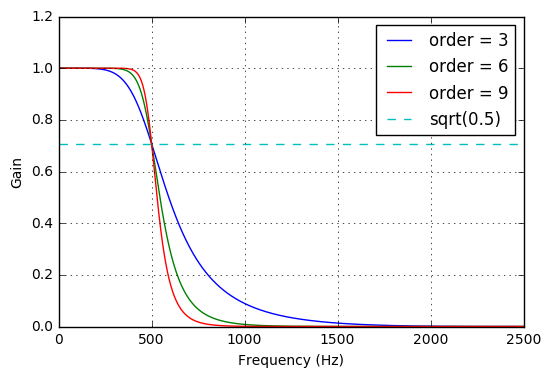

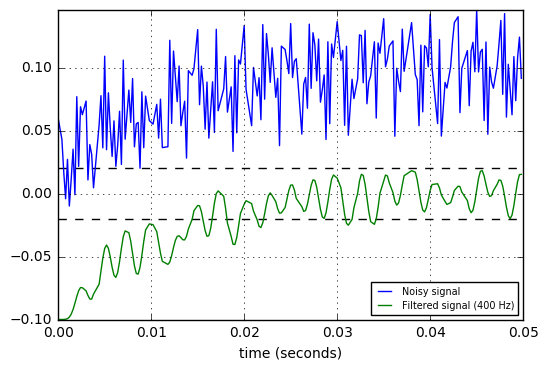

In [8]:
run_worse_sampling()

In [9]:
def get_data():                                                                                                                                                                                                                                                                   
    '''                                                                                                                                                                                                                                                                           
    Get flux vs time for a random quarter of data.                                                                                                                                                                                                                                
    '''                                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                  
    origstage = 'dipsearch_inj'                                                                                                                                                                                                                                                   
    δ = 1/16./100. # try to ignore injection                                                                                                                                                                                                                                      
    stage = origstage + '_' + str(δ)                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                  
    df = pd.read_csv('../results/injrecovresult/irresult_sap_top1.csv')                                                                                                                                                                                                           
    kicids = np.unique(df['kicid'])                                                                                                                                                                                                                                               
    kicid_ind = np.random.randint(low=0, high=len(kicids))                                                                                                                                                                                                                        
    kicid = kicids[kicid_ind]                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                  
    lcd = load_lightcurve_data(kicid, stage=stage)                                                                                                                                                                                                                             
    allq = load_allq_data(kicid, stage=stage)                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                                                  
    qnums = list(lcd.keys())                                                                                                                                                                                                                                                      
    qnum = np.random.randint(low=min(qnums), high=max(qnums))                                                                                                                                                                                                                     
    while qnum not in qnums:                                                                                                                                                                                                                                                      
        qnum = np.random.randint(low=min(qnums), high=max(qnums))                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                                  
    lc = lcd[qnum]['redtr']['sap']                                                                                                                                                                                                                                                
    fluxs = lc['fluxs'] - lc['fitfluxs_legendre']                                                                                                                                                                                                                                 
    times = lc['times']                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                  
    kebc_period = float(lcd[list(lcd.keys())[0]]['kebwg_info']['period'])                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                  
    return times, fluxs, kicid, kebc_period 

In [10]:
def inject_nominal_system(times, fluxs, eb_period):
    import batman
    import astropy.units as u
    # Inject at P_CBP uniformly between 10-15x P_EB.                                                                                                                                                                 
    pref = 10 + 5*np.random.rand()                                                                                                                                                                                   
    period_cbp = pref*eb_period
    
    params = batman.TransitParams()                                                                                                                                                                                  
    injphase = np.random.rand()                                                                                                                                                                                      
    params.t0 = min(times) + injphase*period_cbp                                                                                                                                                                        
    params.per = period_cbp                                                                                                                                                                                          
    params.rp = 0.01**(1/2.)                                                                                                                                                                                         
    a_in_AU = (period_cbp*u.day/u.yr)**(2/3.)                                                                                                                                                                        
    Rstar_in_AU = (u.Rsun/u.au)                                                                                                                                                                                      
    params.a = a_in_AU.cgs.value / Rstar_in_AU.cgs.scale                                                                                                                                                             
    params.inc = 89.                                                                                                                                                                                                 
    params.ecc = 0.                                                                                                                                                                                                  
    params.w = 90.                                                                                                                                                                                                   
    params.u = [0.1, 0.3]                                                                                                                                                                                            
    params.limb_dark = "quadratic"                                                                                                                                                                                   
                                                                                                                                                                                                                     
    exp_time_minutes = 29.423259                                                                                                                                                                                     
    exp_time_days = exp_time_minutes / (24.*60)                                                                                                                                                                      
                                                                                                                                                                                                                     
    ss_factor = 10                                                                                                                                                                                                   
    # Initialize model                                                                                                                                                                                               
    m_toinj = batman.TransitModel(params,                                                                                                                                                                            
                            times,                                                                                                                                                                                   
                            supersample_factor = ss_factor,                                                                                                                                                          
                            exp_time = exp_time_days)                                                                                                                                                                
                                                                                                                                                                                                                     
                                                                                                                                                                                                                   
    # Calculate light curve                                                                                                                                                                                          
    fluxtoinj = m_toinj.light_curve(params) - 1.
    
    flux_with_inj = fluxs+fluxtoinj
                                                                                                                                                                                                                     
    return flux_with_inj
        

def butter_kepler():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz
    
    times, fluxs, kicid, eb_period_days = get_data()
    flux_with_inj = inject_nominal_system(times, fluxs, eb_period_days)
    
    Δt_days = np.median(np.diff(times))
    Δt_sec = Δt_days/(24.*60*60)
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 1/Δt_sec
    eb_period_sec = eb_period_days/(24.*60*60)
    # factor of 2 from Holman & Wiegert stability arguments
    lowcut = 1/(2*eb_period_sec)
    
    # Plot the frequency response for a few different orders.
    plt.close('all')
    f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    ax0, ax1 = axs[0], axs[1]
    for order in [6, 9, 12]:
        b, a = butter_bandpass(lowcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        ax0.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    ax0.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    ax0.set_xlabel('Frequency (Hz)')
    ax0.set_ylabel('Gain')
    ax0.set_xscale('log')
    ax0.grid(True)
    ax0.legend(loc='best', fontsize='x-small')
       
    # Filter a noisy signal.   
    ax1.plot(times, flux_with_inj, label='dtr flux')

    order = 9
    fluxs_filt = butter_bandpass_filter(flux_with_inj, lowcut, fs, order=order)
    ax1.plot(times, fluxs_filt-2*np.std(flux_with_inj), label='Filtered signal (order {:d})'.format(order))
    ax1.set_xlabel('time (days)')
    ax1.grid(True)
    ax1.axis('tight')
    ax1.legend(loc='best', fontsize='x-small')
    f.savefig('plots/butter_demo/{:s}.png'.format(str(kicid)), dpi=300)

In [11]:
#for _ in range(50):
#    butter_kepler()

Ok, looking at those plots (also linked in /results/eb_subtraction_diagnostics/butter_demo), it's pretty clear that Butterworth aint gonna cut it.

Possible other approaches:
1. Do better _initial_ detrending. When there are systematics in that initial detrend, they come into the fold (& then fuck up subtraction).
2. Iterative PDM -> fit -> subtract down to 0.1% RMS.
3. Keep on the frequency domain route. Try e.g., a bandstop filter approach, per http://mubeta06.github.io/python/sp/firwin.html, with a finite impulse response filter constructed from whatever windows show up as peaks on the PDM spectrum.

(3) is an interesting approach, but it should (in theoory) be quite similar to what we're doing by phase-folding and fitting on the EB signal. Except it might be wonkier, because it'll rely on Fourier techniques, and thus on perfect sampling, while we need to be working in the ~80% throughput range with Kepler data.

Let's try (2).


In [39]:
# Iterative PDM prototype, herewego

def get_data():                                                                                                                                                                                                                                                                   
    '''                                                                                                                                                                                                                                                                           
    Get flux vs time for a random quarter of data.                                                                                                                                                                                                                                
    '''                                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                  
    origstage = 'dipsearch_inj'                                                                                                                                                                                                                                                   
    δ = 1/16./100. # try to ignore injection                                                                                                                                                                                                                                      
    stage = origstage + '_' + str(δ)                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                  
    df = pd.read_csv('../results/injrecovresult/irresult_sap_top1.csv')                                                                                                                                                                                                           
    kicids = np.unique(df['kicid'])                                                                                                                                                                                                                                               
    kicid_ind = np.random.randint(low=0, high=len(kicids))                                                                                                                                                                                                                        
    kicid = kicids[kicid_ind]                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                  
    lcd = load_lightcurve_data(kicid, stage=stage)                                                                                                                                                                                                                             
    allq = load_allq_data(kicid, stage=stage)                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                                                  
    qnums = list(lcd.keys())                                                                                                                                                                                                                                                      
    qnum = np.random.randint(low=min(qnums), high=max(qnums))                                                                                                                                                                                                                     
    while qnum not in qnums:                                                                                                                                                                                                                                                      
        qnum = np.random.randint(low=min(qnums), high=max(qnums))                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                                  
    lc = lcd[qnum]['redtr']['sap']                                                                                                                                                                                                                                                
    fluxs = lc['fluxs'] - lc['fitfluxs_legendre']                                                                                                                                                                                                                                 
    times = lc['times']                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                  
    kebc_period = float(lcd[list(lcd.keys())[0]]['kebwg_info']['period'])                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                  
    return times, fluxs, kicid, kebc_period, qnum, lcd, allq

def iterate_one_PDM():
    
    times, fluxs, kicid, eb_period_days, qnum, lcd, allq = get_data()
    #flux_with_inj = inject_nominal_system(times, fluxs, eb_period_days)
    
    lcd = lcd[qnum]
    
    # like run_periodograms_all_quarters
    rd = {}
    rd[qnum] = run_periodogram(lcd, qnum, 'pdm', iter_n=1)
    
    #NOTE you could not overwrite lcd if you only want certain udpated pieces
    lcd = select_eb_period(rd, fine=False)
    rd = {}
    rd[qnum] = run_fineperiodogram(lcd[qnum], qnum, iter_n=1)
    lcd = select_eb_period(rd, fine=True)
    rd = {}
    rd[qnum] = whiten_lightcurve(lcd[qnum], qnum, σ_clip=[30.,5.], iter_n=1)
    
    return rd, allq
    
def plot_iterwhiten_3row(lcd, allq, ap='sap', stage='', inj=False):
                                                                                                                                                                                                                     
    assert ap == 'sap' or ap == 'pdc'                                                                                                                                                                                
                                                                                                                                                                                                                     
    keplerid = lcd[list(lcd.keys())[0]]['objectinfo']['keplerid']                                                                                                                                                    
                                                                                                                                                                                                                                                                                                                                                                                                                                         
    # Set up matplotlib figure and axes.                                                                                                                                                                             
    plt.close('all')                                                                                                                                                                                                 
    nrows, ncols = 3, 2
    f = plt.figure(figsize=(16, 10))                                                                                                                                                                                 
    gs = GridSpec(nrows, ncols) # 5 rows, 5 columns                                                                                                                                                                  
                                                                                                                                                                                                                     
    # row 0: dtr timeseries                                                                                                                                                                                      
    ax_dtr = f.add_subplot(gs[0,:])                                                                                                                                                                                  
    # row 2: detrended & normalized                                                                                                                                                                                  
    ax_w = f.add_subplot(gs[2,:], sharex=ax_dtr)  
    # row1, col0: PDM periodogram
    ax_pg = f.add_subplot(gs[1,0])
    # row1, col1: phase-folded dtr 
    ax_pf = f.add_subplot(gs[1,1])
                                                                                                                                                                                                                                                                                                                                                                                                                                     
    LOGINFO('Beginning whitened plot. KEPID %s (%s)' % (str(keplerid), ap))                  
    
    # TIMESERIES
    qnum = list(lcd.keys())[0]
    for axix, ax in enumerate([ax_dtr, ax_w]):
        if axix == 0:
            lc = lcd[qnum]['redtr'][ap]
            times = lc['times']
            #FIXME: remove this
            fluxs = lc['fluxs'] - lc['fitfluxs_legendre']
            #fluxs = lc['fluxs_redtr']            
            errs = lc['errs']
                    
        elif axix == 1:
            lc = lcd[qnum]['white'][ap]['whiteseries']
            times = lc['times']
            fluxs = lc['fluxes']
            errs = lc['errs']

        meanflux = np.mean(fluxs)                                                                                                                                                                                    
        rms_biased = float(np.sqrt(np.sum((fluxs-meanflux)**2) / len(fluxs)))  

        ax.plot(times, fluxs, linestyle='-', marker='o',
               markerfacecolor='black', markeredgecolor='black',
               ms=1, lw=0.2)
        
        txt = 'RMS: %.4g' % (rms_biased)                                                                                                                                                                                  
        ax.text(0.02, 0.02, txt, horizontalalignment='left',                                                                                                                                                        
            verticalalignment='bottom',                                                                                                                                                                             
            transform=ax.transAxes)  
        
    ax_dtr.set(ylabel='redtr flux')
    ax_pg.set(ylabel='PDM power')
    
    # PERIODOGRAM
    ax_pg.plot(lcd[qnum]['per'][ap]['periods'],
              lcd[qnum]['per'][ap]['lspvals'],
              'k-')

    selperiod = lcd[qnum]['fineper'][ap]['selperiod']                                                                                                                                                            
    inj_period = allq['inj_model']['params'].per
    pwr_ylim = ax_pg.get_ylim()
    ax_pg.vlines(selperiod, min(pwr_ylim), max(pwr_ylim), colors='r', linestyles='--', alpha=0.8,
                 zorder=20, label='P_sel')
    ax_pg.vlines(eb_period_days, min(pwr_ylim), max(pwr_ylim), colors='g', linestyles='--', alpha=0.8,
             zorder=20, label='P_EB')
    ax_pg.vlines(inj_period, min(pwr_ylim), max(pwr_ylim), colors='b', linestyles=':', alpha=0.8,
             zorder=20, label='P_CBP')
    ax_pg.legend(fontsize='xx-small', loc='lower right')
    ax_pg.set_ylim(pwr_ylim)
    ax_pg.set(xscale='log')
    
    # PHASE-FOLD
    pflux = lcd[qnum]['white'][ap]['magseries']['mags']                                                                                                                                                          
    phase = lcd[qnum]['white'][ap]['magseries']['phase']                                                                                                                                                         
    pfitflux = lcd[qnum]['white'][ap]['fitinfo']['fitmags']                                                                                                                                                      

    thiscolor = 'blue'
    ax_pf.plot(phase, pflux, c=thiscolor, linestyle='-',                                                                                                                                                            
            marker='o', markerfacecolor=thiscolor,                                                                                                                                                               
            markeredgecolor=thiscolor, ms=0.1, lw=0.1, zorder=0)                                                                                                                                                 
    ax_pf.plot(phase, pfitflux, c='k', linestyle='-',                                                                                                                                                               
            lw=0.5, zorder=2)                                                                                                                                                                                    

    selperiod = lcd[qnum]['fineper'][ap]['selperiod']                                                                                                                                                            

    txt = 'q: %d' % (int(qnum))                                                                                                                                                                                  
    ax_pf.text(0.98, 0.98, txt, horizontalalignment='right',                                                                                                                                                        
            verticalalignment='top',                                                                                                                                                                             
            transform=ax_pf.transAxes)                                                                                                                                                                              

    pf_txt = 'P_EB: %.7f day\nP_sel: %.7f day' % (eb_period_days, selperiod)                                                                                                                                       
    ax_pf.text(0.02, 0.02, pf_txt, horizontalalignment='left',                                                                                                                                                      
            verticalalignment='bottom', transform=ax_pf.transAxes)                                                                                                                                                  
    ax_pf.set(ylabel='phased redtr flux')             
    
    f.tight_layout()
    f.savefig('plots/iterwhiten_demo/{:s}.png'.format(str(keplerid)), dpi=300,
             bbox_inches='tight')

2017-03-16T19:33:02.711812Z [INFO]: Loaded pickled data from ../data/injrecov_pkl/inj/4850874_dipsearch_inj_0.000625.p
2017-03-16T19:33:02.815203Z [INFO]: Loaded allquarter pickled data from ../data/injrecov_pkl/inj/4850874_allq_dipsearch_inj_0.000625.p
2017-03-16T19:33:02.817452Z [INFO]: using autofreq with 9688 frequency points, start P = 0.050, end P = 20.000
2017-03-16T19:33:02.817481Z [INFO]: using 16 workers...
2017-03-16T19:33:05.411198Z [INFO]: KIC ID 4850874, computed periodogram (pdm) quarter 11. (sap)
2017-03-16T19:33:05.412475Z [INFO]: using autofreq with 9686 frequency points, start P = 0.050, end P = 20.000
2017-03-16T19:33:05.412504Z [INFO]: using 16 workers...
2017-03-16T19:33:07.950302Z [INFO]: KIC ID 4850874, computed periodogram (pdm) quarter 11. (pdc)
2017-03-16T19:33:07.951567Z [INFO]: using 10610 frequency points, start P = 1.775, end P = 1.845
2017-03-16T19:33:07.951596Z [INFO]: using 16 workers...
2017-03-16T19:33:11.101068Z [INFO]: KIC ID 4850874 computed fine 

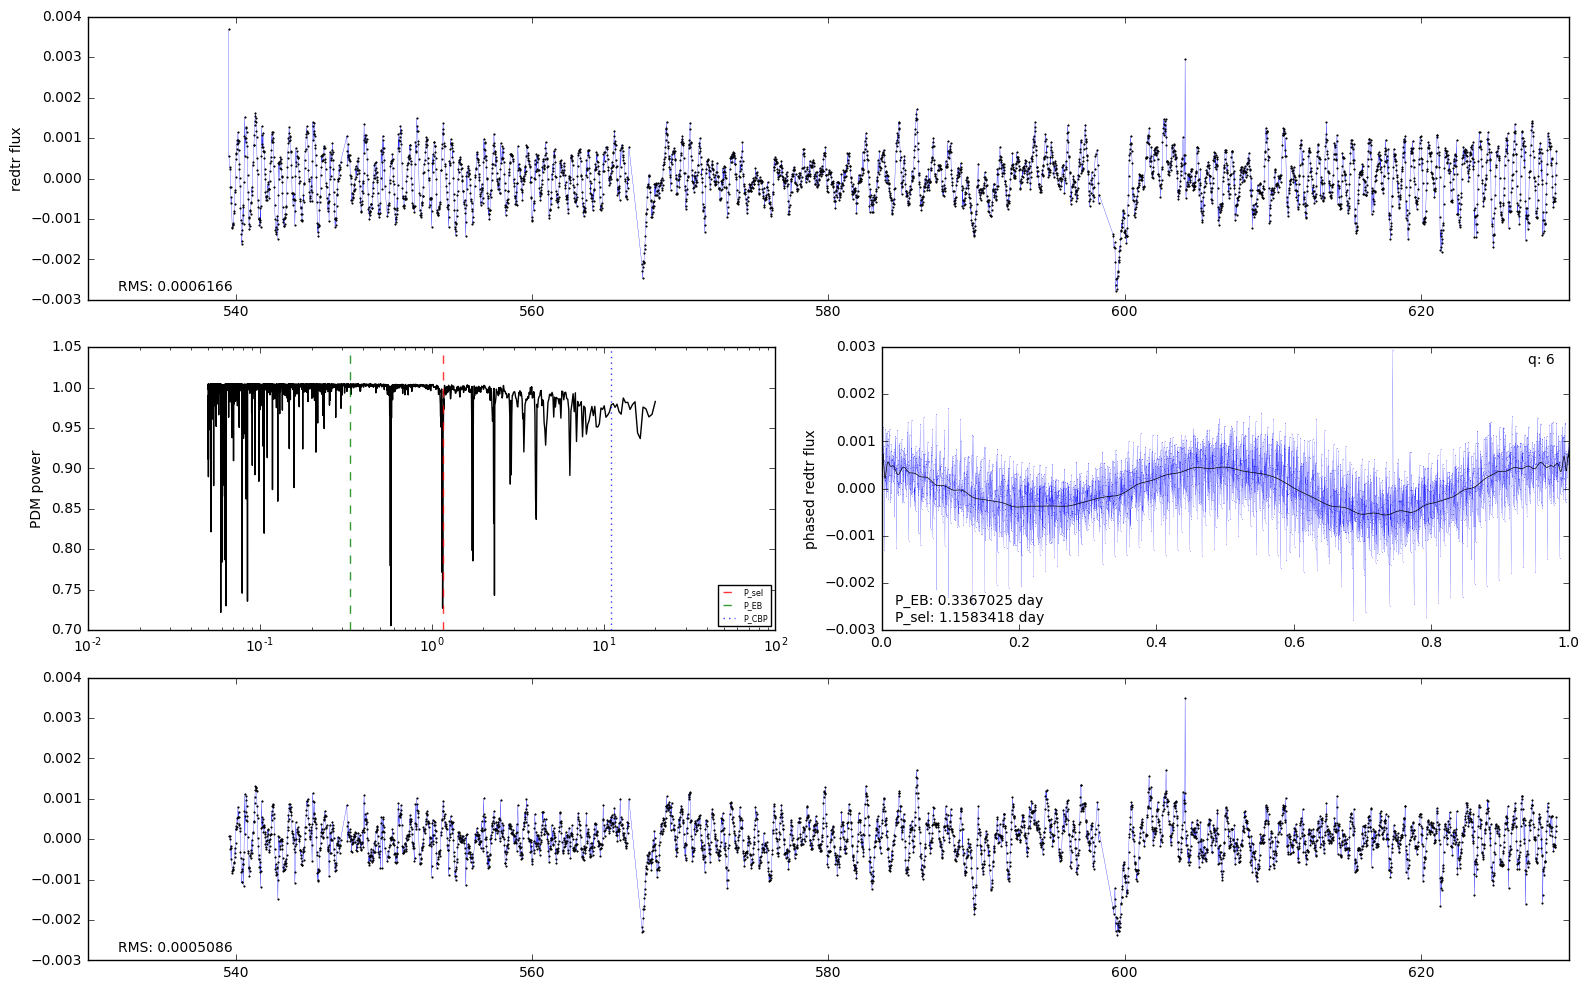

In [42]:
def iterwhiten_demo():
    lcd, allq = iterate_one_PDM()
    plot_iterwhiten_3row(lcd, allq)
    
#for _ in range(50):
#    iterwhiten_demo()

In [ ]:



def bandstop_filter_kepler():
    '''
    Apply selective window filters on the data at frequencies that the EB peaks(?)
    '''
    pass